In [1]:
import numpy as np
import os
from sklearn.manifold import Isomap, LocallyLinearEmbedding, SpectralEmbedding
from tqdm import tqdm_notebook
from collections import defaultdict
from sklearn.neighbors import KNeighborsRegressor, NearestNeighbors
from sklearn.metrics import make_scorer, r2_score
from sklearn.multioutput import MultiOutputRegressor, RegressorChain
from sklearn.model_selection import cross_val_score, cross_validate, ParameterGrid, GridSearchCV
from lightgbm import LGBMRegressor
import multiprocessing
from joblib import Parallel, delayed
from utils import mae_score
import matplotlib.pyplot as plt
from utils import project, NPR


Bad key "text.kerning_factor" on line 4 in
/media/hpc2_storage/ibulygin/miniconda3/envs/fresh/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
# paths for the pivot tables
MERGED = False

if MERGED:
    root = './merged_datasets_proj/'
    paths = [os.path.join(root,path) for path in os.listdir(root)]
    intrinsic_dims = np.load('intrinsic_dims_merged.npy',allow_pickle=True).item()
else:
    root = './separate_datasets_proj/'
    paths = [os.path.join(root,path) for path in os.listdir(root)]
    intrinsic_dims = np.load('intrinsic_dims_separate.npy',allow_pickle=True).item()

In [3]:
intrinsic_dims

{'./separate_datasets_proj/ptb_proj_f.csv': array([5, 6, 7]),
 './separate_datasets_proj/AGP_proj_o.csv': array([4, 5, 6]),
 './separate_datasets_proj/t2d_proj_f.csv': array([4, 5, 6]),
 './separate_datasets_proj/ibd_proj_o.csv': array([2, 3]),
 './separate_datasets_proj/t2d_proj_g.csv': array([4, 5, 6]),
 './separate_datasets_proj/ptb_proj_g.csv': array([5, 6, 7]),
 './separate_datasets_proj/ptb_proj_o.csv': array([4, 5]),
 './separate_datasets_proj/AGP_proj_f.csv': array([6, 7, 8, 9]),
 './separate_datasets_proj/AGP_proj_g.csv': array([7, 8, 9]),
 './separate_datasets_proj/ibd_proj_f.csv': array([3, 4]),
 './separate_datasets_proj/t2d_proj_o.csv': array([2, 3, 4, 5]),
 './separate_datasets_proj/ibd_proj_g.csv': array([2, 3, 4, 5])}

In [4]:
label2path = {}
for path in paths:
    label = path.split("/")[-1].split(".")[0] # take dataset name
    label2path[label] = path

In [5]:
label2path

{'ptb_proj_f': './separate_datasets_proj/ptb_proj_f.csv',
 'AGP_proj_o': './separate_datasets_proj/AGP_proj_o.csv',
 't2d_proj_f': './separate_datasets_proj/t2d_proj_f.csv',
 'ibd_proj_o': './separate_datasets_proj/ibd_proj_o.csv',
 't2d_proj_g': './separate_datasets_proj/t2d_proj_g.csv',
 'ptb_proj_g': './separate_datasets_proj/ptb_proj_g.csv',
 'ptb_proj_o': './separate_datasets_proj/ptb_proj_o.csv',
 'AGP_proj_f': './separate_datasets_proj/AGP_proj_f.csv',
 'AGP_proj_g': './separate_datasets_proj/AGP_proj_g.csv',
 'ibd_proj_f': './separate_datasets_proj/ibd_proj_f.csv',
 't2d_proj_o': './separate_datasets_proj/t2d_proj_o.csv',
 'ibd_proj_g': './separate_datasets_proj/ibd_proj_g.csv'}

In [6]:
def transform(method, dim, X, parameters):
    model_inst = method(n_components=dim, **parameters)
    d_trans = model_inst.fit_transform(X)
    re = model_inst.reconstruction_error_ if hasattr(model_inst, 'reconstruction_error_') else model_inst.reconstruction_error()
    return [re, d_trans]

# Find best MF in terms of KNN regression MAE error

In [7]:
mf_models = {'isomap':{'class':Isomap, 'params_grid':{'n_neighbors':[10,15,25,50, 75, 100],
                                                      'p':[1,2,3],
                                                      'n_jobs':[-1]}},
             'lle':{'class':LocallyLinearEmbedding, 'params_grid':{'method':['modified'],
                                                                   'eigen_solver':['dense'],
                                                                   'n_neighbors':[10,15,25,50,75, 100],
                                                                   'random_state':[42],
                                                                   'n_jobs':[-1]}}
            }


scorer_neg_mae = make_scorer(mae_score, greater_is_better=False)
scorer_r2 = make_scorer(r2_score, greater_is_better=True)

results = defaultdict(dict)
dataset_iterator = [''] if MERGED else ['AGP', 'ptb']
for i,dataset_name in tqdm_notebook(enumerate(dataset_iterator)):
    for j,tax_name in enumerate(['o', 'f', 'g']):
    
        label = '_'.join(['proj', tax_name]) if MERGED else '_'.join([dataset_name, 'proj', tax_name])   
        path = label2path[label]
        d = np.genfromtxt(path, delimiter=';')
        assert not np.isnan(d).any()
        dims = intrinsic_dims[path]
        
#         d1 = min(2, min(dims))
#         d2 = min(d.shape[1], max(dims)+6)
        DIM_RANGE = dims #np.arange(d1, d2)

        for mf_type, model in mf_models.items():
            metric_dict = defaultdict(list)
            for dim in DIM_RANGE:
                model_class = model['class']
                model_param_grid = model['params_grid']
#                 if mf_type == 'lle':
#                     model_param_grid['n_neighbors'] = list(filter(lambda x: x>=d2, model_param_grid['n_neighbors']))
                # looking for best params for 
                gridsearch_results = Parallel(n_jobs=-1)(delayed(transform)(model_class, dim, d, model_params) \
                                                         for model_params in ParameterGrid(model_param_grid))              
                re_s = [r[0] for r in gridsearch_results]
                d_trans_s = [r[1] for r in gridsearch_results]
                min_re_index = np.argmin(re_s)
                
                d_trans = d_trans_s[min_re_index] 
                re = re_s[min_re_index]

#                 knn = KNeighborsRegressor(n_neighbors=dim*2, weights='distance', n_jobs=-1)
#                 gridsearch = GridSearchCV
                knn = LGBMRegressor()
                mo_knn = RegressorChain(knn)
#                 mo_knn = MultiOutputRegressor(knn)
                cv_results_neg_mae= cross_val_score(mo_knn, d_trans, d, scoring=scorer_neg_mae, cv=5, n_jobs=-1)

                metric_dict['re'].append(re)
                metric_dict['re_s'].append(re_s)
                metric_dict['knn_neg_mae'].append(-cv_results_neg_mae.mean())
                metric_dict['npr'].append(NPR(d, d_trans, k=10))
                metric_dict['dataset_transformed'].append(d_trans)

            results[label][mf_type] = metric_dict

# Visualization

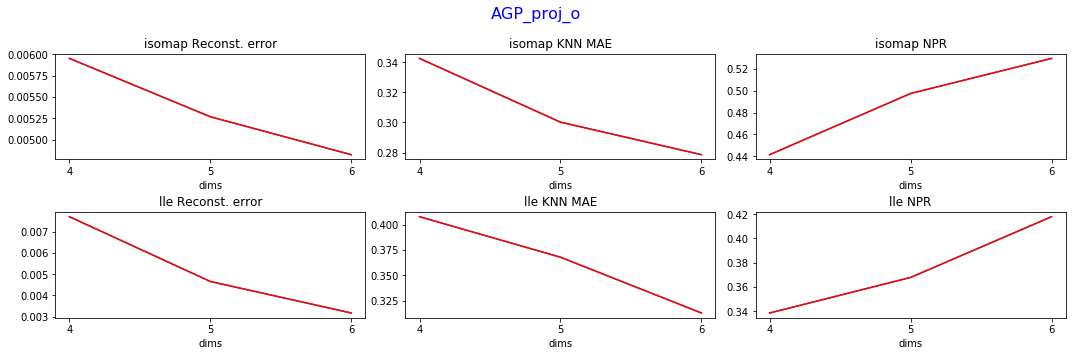

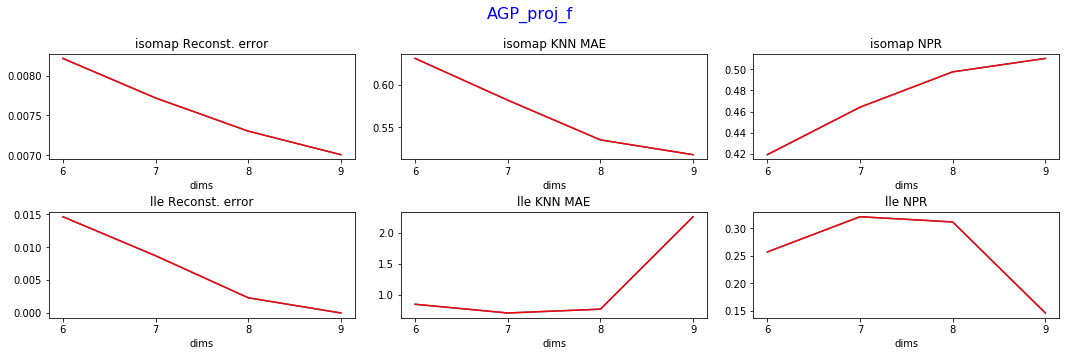

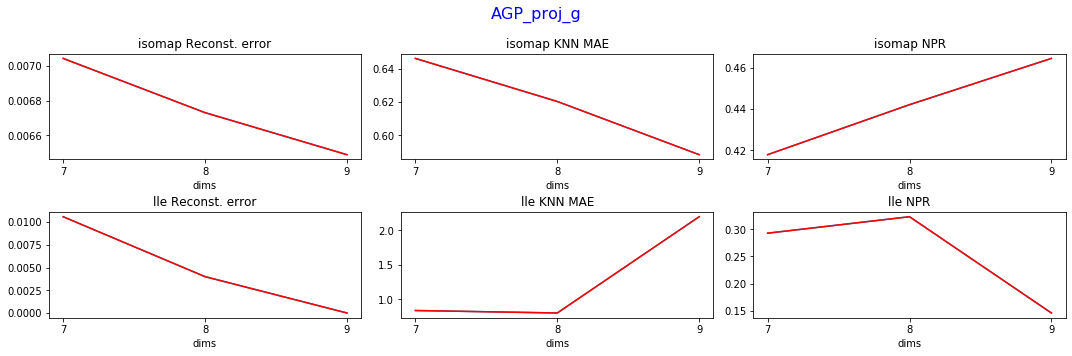

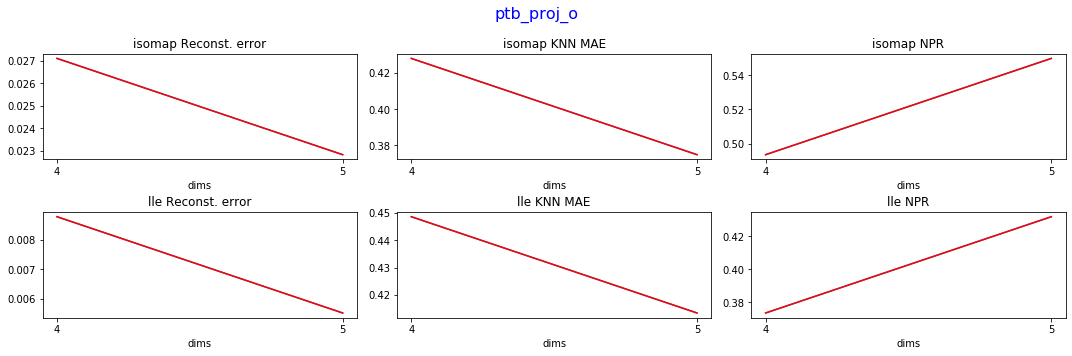

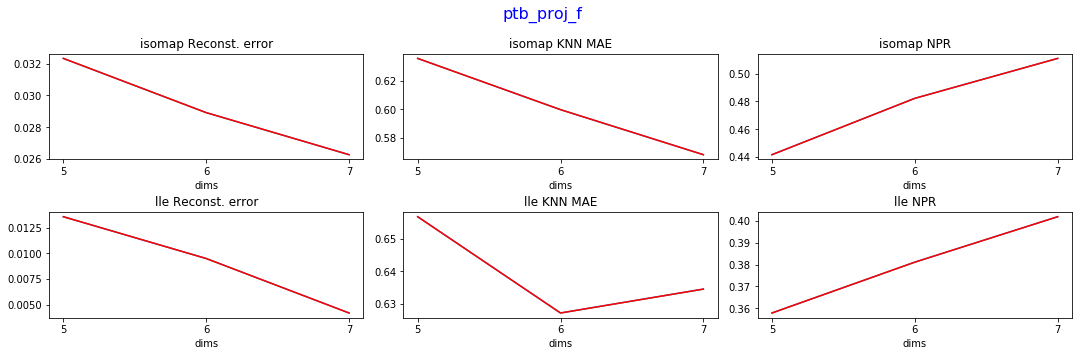

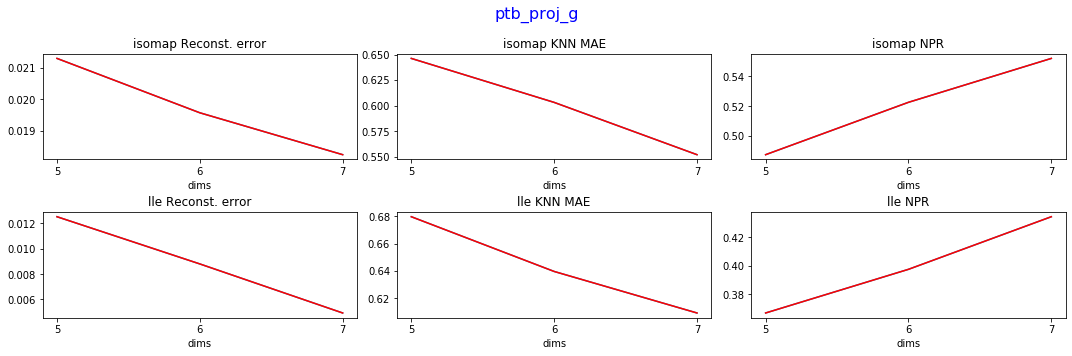

In [20]:
for dataset_name, mf_results_dict in results.items():
    fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(15,5))
    for i,(mf_method, metrics) in enumerate(mf_results_dict.items()):
        path = label2path[dataset_name]
        recommended_intrinsic_dims = intrinsic_dims[path]
        dims = intrinsic_dims[path]
        re = np.array(metrics['re'])
        knn_mae = np.array(metrics['knn_neg_mae'])
        npr = np.array(metrics['npr'])
        
        d = np.genfromtxt(path, delimiter=';')
#         d1 = min(2, min(recommended_intrinsic_dims))
#         d2 = min(d.shape[1], max(recommended_intrinsic_dims)+6)
        DIM_RANGE = dims #np.arange(d1, d2)
        
        ind = np.intersect1d(DIM_RANGE, recommended_intrinsic_dims, assume_unique=True, return_indices=True)[1].tolist()
        
        axes[i,0].plot(DIM_RANGE, re)
        axes[i,0].set_title(mf_method + ' Reconst. error')
        axes[i,0].plot(recommended_intrinsic_dims, re[ind], 'r')
        axes[i,0].set_xticks(ticks=DIM_RANGE)
        axes[i,0].set_xticklabels(DIM_RANGE)
        axes[i,0].set_xlabel('dims')
        
        axes[i,1].plot(DIM_RANGE, knn_mae)
        axes[i,1].set_title(mf_method + ' KNN MAE')
        axes[i,1].plot(recommended_intrinsic_dims, knn_mae[ind], 'r')
        axes[i,1].set_xticks(ticks=DIM_RANGE)
        axes[i,1].set_xticklabels(DIM_RANGE)
        axes[i,1].set_xlabel('dims')
        
        axes[i,2].plot(DIM_RANGE, npr)
        axes[i,2].set_title(mf_method + ' NPR')
        axes[i,2].plot(recommended_intrinsic_dims, npr[ind], 'r')
        axes[i,2].set_xticks(ticks=DIM_RANGE)
        axes[i,2].set_xticklabels(DIM_RANGE)
        axes[i,2].set_xlabel('dims')
        
    fig.suptitle(dataset_name, fontsize=16, color='blue')
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    
plt.show()

In [23]:
np.sqrt(0.125)

0.3535533905932738

# Saving

In [11]:
# SAVE = True

# for label,label_dict in results.items(): 
#     for method_name, method_dict in label_dict.items(): 
#         recommended_intrinsic_dims = intrinsic_dims[label2path[label]]
        
#         d = np.genfromtxt(path, delimiter=';')
#         dims = intrinsic_dims[path]
#         d1 = min(2, min(dims))
#         d2 = min(d.shape[1], max(dims)+6)
#         DIM_RANGE = np.arange(d1, d2)

#         mae = np.array(method_dict['knn_neg_mae'])

#         ind = np.intersect1d(DIM_RANGE, recommended_intrinsic_dims, assume_unique=True, return_indices=True)[1].tolist()
#         i = ind[np.array(mae)[ind].argmin()]

#         d_trans = method_dict['dataset_transformed'][i]
        
#         if SAVE:
#             if MERGED:
#                 name = f"./merged_datasets_transformed/{label}_{method_name}.csv"
#             else:
#                 name = f"./separate_datasets_transformed/{label}_{method_name}.csv"
#             np.savetxt(name, d_trans, delimiter=";")